# Recurent SNN Batch Size Test

This notebook takes pre-trained weights from a recurrent ANN and uses them to perform inference using a network of spiking neurons.

Spiking network must be the same shape as the pre-trained ANN. Must also use same dataset used to train ANN.

ANN must use ReLU as the nonlinear activation between layers.

Performs weight balancing on all layers.

Effects to be studied:
- batch size effect on accuracy
- batch size-delay mismatch rectification method effect on accuracy
    - extrapolate
    - reuse

## Imports

In [2]:
import torch
import struct
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from SpikingNetwork import SNN, poisson_train

## Load ANN Model

In [3]:
# specify file name and directory of ANN then load

model_dir = "Recurrent ANN Models//"
model_name = "RANN_2.pth"

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        """ Builds feed-forward layers """
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(64, 48, bias=False),
            nn.ReLU(),
        )
        self.rnn = nn.RNN(48, 16, nonlinearity='relu', bias=False)
        self.out = nn.Sequential(
            nn.Linear(16, 6, bias=False),
            nn.LogSoftmax(dim=1),
        )
        
        # build mask for recurrent layer (hh weights -- no self-connect)
        self.mask = torch.ones(16, 16).to(device)
        dia_ind = np.diag_indices(self.mask.shape[0])
        self.mask[dia_ind[0], dia_ind[1]] = torch.zeros(self.mask.shape[0]).to(device)
        
        # set loss function
        self.loss_fn = nn.NLLLoss()

        # prepare threshold balancing
        self.h_max = 0

    def forward(self, q, single=False, thresh_bal=False):
        """ Implements feed-forward then recurrent layers """
        ff_q = []
        for word in q:
            ff_q.append(self.ff(word))
        ff_q = torch.stack(ff_q)
        h_N = Variable(torch.zeros(1, 16)).to(device)
        rnn_out = Variable(torch.zeros(1, 16)).to(device)
        self.rnn._parameters['weight_hh_l0'].data.mul_(self.mask)
        i = 0
        for word in ff_q:
            if not torch.all(word.eq(0)):
                #word = word / word.sum().item()
                word = word / torch.max(word) # normalize
                rnn_out, h_N = self.rnn(word, h_N)
                if thresh_bal:
                    self.h_max = np.max([self.h_max, torch.max(h_N).item()])
                i += 1
                if single:
                    print("rnn out {0}:".format(i))
                    print(rnn_out)
            else:
                break
        output = self.out(rnn_out)
        if single:
            print("output:")
            print(output)
        return output

# load pre-trained ANN 
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(model_dir + model_name))
print(model)

Using cuda device
NeuralNetwork(
  (ff): Sequential(
    (0): Linear(in_features=64, out_features=48, bias=False)
    (1): ReLU()
  )
  (rnn): RNN(48, 16, bias=False)
  (out): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=False)
    (1): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
)


## Load Data

In [4]:
# prepare word2vector vocabulary (ty chatGPT :) )

def read_word_vectors(filepath):
    with open(filepath, 'rb') as f:
        header = f.readline()
        vocab_size, vector_size = map(int, header.split())
        binary_len = np.dtype('float32').itemsize * vector_size
        word_vectors = {}

        for _ in range(vocab_size):
            word = []
            while True:
                ch = f.read(1)
                if ch == b' ':
                    break
                if ch != b'\n':
                    word.append(ch)
            word = b''.join(word).decode('utf-8')
            vector = np.frombuffer(f.read(binary_len), dtype='float32')
            word_vectors[word] = vector

    return word_vectors

def get_word_vector(word, word_vectors):
    return word_vectors.get(word)

# Load the word vectors
word_vectors = read_word_vectors('..\\Data\\true_vectors.bin')

In [5]:
# Load and prepare data

# load data
f = open("..\\Data\\Training Data\\train_5500.txt")
data = f.read()

# split data into sentences
sents = data.split('\n')

# split each sentence into words
for i in range(len(sents)):
    sents[i] = sents[i].split(' ')[:-1]

# perform conversion
vec_data = []
for sent in sents[:-1]:
    vecs = []
    vecs.append(sent[0])
    for word in sent[1:]:
        try:
            word = word.lower()
            vec = get_word_vector(word, word_vectors)
            vecs.append(torch.from_numpy(vec))
        except:
            pass
    vecs.append(torch.zeros(64))
    vec_data.append(vecs)

# pad all sentences to length of longest sentence
max_len = max([len(sent) for sent in vec_data])
vec_data_pad = []
for sent in vec_data:
    pad_len = max_len - len(sent)
    for i in range(pad_len):
        sent.append(torch.zeros(64))
    vec_data_pad.append(sent)
vec_data = vec_data_pad
    
# split into training and test data
train_data = vec_data[:5000]
test_data = vec_data[5000:-1]

C:\Users\Liamr\AppData\Local\Temp\ipykernel_18656\2980431855.py:23: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  vecs.append(torch.from_numpy(vec))


In [6]:
# create custom DataSet then make Dataloader

ans_key = { 'DESC' :  0,
            'ENTY' :  1,
            'ABBR' :  2,
            'HUM'  :  3,
            'LOC'  :  4,
            'NUM'  :  5
            }

class QuestionDataset(Dataset):
    """ Question Dataset """
    
    def __init__(self, data):
        """
        data = list of (list of words -- first word is label)
        """
        self.labels = []
        self.sents = []
        for sent in data:
            lab_val = ans_key[sent[0].split(":")[0]]
            lab_arr = torch.tensor(lab_val)
            self.labels.append(lab_arr)
            self.sents.append(sent[1:])
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sent = self.sents[idx]
        label = self.labels[idx]
        return sent, label

train_DSet = QuestionDataset(train_data)
test_DSet = QuestionDataset(test_data)

# Create data loader
batch_size = 1
train_dataloader = DataLoader(train_DSet, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_DSet, batch_size=batch_size, shuffle=True)

In [7]:
# run a test epoch

# define test routine
def test_ANN(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    i = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = torch.stack(X).to(device), y.to(device) #torch.FloatTensor(y).to(device)
            pred = model(X)
            test_loss += model.loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print("Actual: {0} -- Inferred: {1}".format(y.item(), pred.argmax(1).item()))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

test_ANN(test_dataloader, model)

Actual: 2 -- Inferred: 2
Actual: 1 -- Inferred: 1
Actual: 4 -- Inferred: 4
Actual: 4 -- Inferred: 4
Actual: 0 -- Inferred: 1
Actual: 3 -- Inferred: 3
Actual: 3 -- Inferred: 3
Actual: 0 -- Inferred: 0
Actual: 0 -- Inferred: 0
Actual: 5 -- Inferred: 5
Actual: 4 -- Inferred: 4
Actual: 3 -- Inferred: 3
Actual: 0 -- Inferred: 0
Actual: 0 -- Inferred: 0
Actual: 0 -- Inferred: 0
Actual: 1 -- Inferred: 1
Actual: 3 -- Inferred: 3
Actual: 5 -- Inferred: 5
Actual: 1 -- Inferred: 1
Actual: 1 -- Inferred: 1
Actual: 1 -- Inferred: 1
Actual: 4 -- Inferred: 4
Actual: 3 -- Inferred: 3
Actual: 3 -- Inferred: 3
Actual: 5 -- Inferred: 5
Actual: 1 -- Inferred: 1
Actual: 1 -- Inferred: 1
Actual: 5 -- Inferred: 5
Actual: 3 -- Inferred: 3
Actual: 1 -- Inferred: 1
Actual: 5 -- Inferred: 5
Actual: 4 -- Inferred: 4
Actual: 0 -- Inferred: 0
Actual: 0 -- Inferred: 0
Actual: 4 -- Inferred: 4
Actual: 0 -- Inferred: 0
Actual: 3 -- Inferred: 3
Actual: 0 -- Inferred: 0
Actual: 1 -- Inferred: 1
Actual: 1 -- Inferred: 1


## Transfer Weights to SNN

In [8]:
# get weights from ANN

param_list = [*model.parameters()]
i = 0
for lay in param_list:
    i += 1
    print("Layer {0}".format(i))
    print(lay.shape)
    print(lay)

w_1 = param_list[0].cpu().detach().numpy()
w_2 = param_list[1].cpu().detach().numpy() # rec layer from prev layer (input)
w_3 = param_list[2].cpu().detach().numpy() # rec layer from hidden layer
w_4 = param_list[3].cpu().detach().numpy()

Layer 1
torch.Size([48, 64])
Parameter containing:
tensor([[ 0.1821, -0.0303,  0.1063,  ..., -0.0048, -0.0617, -0.1067],
        [-0.1860, -0.2291, -0.3663,  ..., -0.1416, -0.1631,  0.0703],
        [ 0.3480, -0.1649, -0.0959,  ..., -0.3409,  0.0330, -0.1725],
        ...,
        [ 0.4453,  0.0620,  0.0944,  ..., -0.2602,  0.0875, -0.0604],
        [-0.0133, -0.0557, -0.1013,  ...,  0.0341,  0.1767,  0.3443],
        [-0.3885, -0.2400, -0.2737,  ..., -0.2318, -0.2289,  0.1329]],
       device='cuda:0', requires_grad=True)
Layer 2
torch.Size([16, 48])
Parameter containing:
tensor([[-8.4344e-02, -5.6351e-01,  3.2299e-01,  1.1083e-01,  2.3529e-01,
          5.8561e-02, -5.5162e-03,  9.8678e-03, -1.8468e-01,  1.1066e-01,
          6.4521e-02, -1.8683e-01,  6.7029e-01, -1.3211e-01, -2.0189e-01,
         -7.2941e-02,  3.3087e-01,  8.6113e-02, -3.1912e-01,  5.3763e-01,
          7.6891e-01, -4.8729e-01, -6.2330e-01, -1.7398e-01,  4.2633e-01,
         -1.5325e-01, -1.1697e-01,  6.4522e-02, -3

In [9]:
# Define model with spiking layer based on trained weights

class SpikingNeuralNetwork(nn.Module):
    def __init__(self):
        """ Builds custom model with added spiking layer """
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(64, 48, bias=False),
            nn.ReLU()
        )
        self.rnn = SNN()
        self.rnn.add_layer(w_2, rec=True, w_r=w_3)
        self.out = nn.Sequential(
            nn.Linear(16, 6, bias=False),
            nn.LogSoftmax(dim=1),
        )
        with torch.no_grad():
            self.ff[0].weight = nn.Parameter(param_list[0].cpu())
            self.out[0].weight = nn.Parameter(param_list[3].cpu())
        
        # set loss function
        self.loss_fn = nn.NLLLoss()
    
    def forward(self, q, t_b, t_d, single=False):
        """ Implements feed-forward then recurrent layer """
        if single:
           global spike_words 
        else:
            spike_words = None
        ff_q = []
        for word in q:
            ff_q.append(self.ff(word))
        ff_q = torch.stack(ff_q)
        i = 0
        for word in ff_q:
            if not torch.all(word.eq(0)):
                i += 1
                #word = word / word.sum().item() # normalize
                word = word / torch.max(word) # normalize
                spike_word = poisson_train(word.cpu().detach().numpy()[0], t_b)
                rnn_out = self.rnn.infer(spike_word, t_b, t_d)
                if single:
                    spike_words.append(spike_word)
                    print("rnn out {0}:".format(i))
                    print(rnn_out)
            else:
                break
        if not single:
            self.rnn.clear_lays()
        if i != 0:
            rnn_out = torch.FloatTensor(np.array([rnn_out])).to(device)
            #rnn_out = rnn_out / rnn_out.sum().item() # normalize
        else:
            rnn_out = Variable(torch.zeros(1, 16)).to(device)
        output = self.out(rnn_out)
        if single:
            print("(post-norm) final rnn out:")
            print(rnn_out)
            print("output:")
            print(output)
        return output

# create model
snn_model = SpikingNeuralNetwork()
snn_model.to(device)
print(snn_model)

SpikingNeuralNetwork(
  (ff): Sequential(
    (0): Linear(in_features=64, out_features=48, bias=False)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=False)
    (1): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
)


In [10]:
# check parameters
snn_param_list = [*snn_model.parameters()]
i=0
for lay in snn_param_list:
    i += 1
    print("Layer {0}".format(i))
    print(lay.shape)
    print(lay)
    
print(snn_model.rnn)
print("Input weight shape: {0}".format(snn_model.rnn.layers[0].w.shape))
print(snn_model.rnn.layers[0].w)
print("Recurrent weight shape: {0}".format(snn_model.rnn.layers[0].w_r.shape))
print(snn_model.rnn.layers[0].w_r)

Layer 1
torch.Size([48, 64])
Parameter containing:
tensor([[ 0.1821, -0.0303,  0.1063,  ..., -0.0048, -0.0617, -0.1067],
        [-0.1860, -0.2291, -0.3663,  ..., -0.1416, -0.1631,  0.0703],
        [ 0.3480, -0.1649, -0.0959,  ..., -0.3409,  0.0330, -0.1725],
        ...,
        [ 0.4453,  0.0620,  0.0944,  ..., -0.2602,  0.0875, -0.0604],
        [-0.0133, -0.0557, -0.1013,  ...,  0.0341,  0.1767,  0.3443],
        [-0.3885, -0.2400, -0.2737,  ..., -0.2318, -0.2289,  0.1329]],
       device='cuda:0', requires_grad=True)
Layer 2
torch.Size([6, 16])
Parameter containing:
tensor([[-0.3760, -0.1176,  0.2059,  0.1100, -0.0372, -0.5878, -0.0152, -0.5267,
          0.4987, -0.1528, -0.4974, -0.5209,  1.6006, -0.5061, -0.1045, -0.7806],
        [ 0.4572,  0.6331,  0.3684, -0.7631, -0.1383, -0.4743,  0.0354, -1.1519,
         -0.4493,  0.1133, -0.6123,  0.3673, -1.2175, -0.3735,  0.1618,  0.7576],
        [-1.1885, -0.9279,  0.8159, -1.2956, -0.3366, -0.4590, -0.4294,  0.1224,
         -0.67

In [11]:
# define test routine
def test_spikes(dataloader, model, t_b, t_d, single=False, verbose=False, compare=False, ann_model=None):
    size = len(dataloader.dataset)
    if single:
        num_batches = 1
    else:
        num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    inf_list, act_list = [], []
    i = 0
    with torch.no_grad():
        #for X, y in tqdm(dataloader):
        for X, y in dataloader:
            X, y = torch.stack(X).to(device), y.to(device)
            if single:
                print("SNN:")
            pred = model.forward(X, t_b, t_d, single)
            if compare:
                if single:
                    print("ANN:")
                pred_ann = ann_model(X, single)
            test_loss += model.loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            inf_list.append(pred.argmax(1).item())
            act_list.append(y.item())
            if verbose:
                if compare:
                    print("Actual: {0} -- Inferred (RNN): {1} - Inferred (ANN): {2}".format(y.item(), pred.argmax(1).item(), pred_ann.argmax(1).item()))
                else:
                    print("Actual: {0} -- Inferred: {1}".format(y.item(), pred.argmax(1).item()))
            if single:
                break
    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return inf_list, act_list

## Perform Threshold Balancing

In [52]:
# perform data-based threshold balancing
model.eval()
for X, y in tqdm(train_dataloader):
    X = torch.stack(X).to(device)
    model.forward(X, thresh_bal=True)
adj_fac = np.max([model.h_max, np.max(w_2), np.max(w_3)])
snn_model.rnn.thresh_bal([adj_fac])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 158.57it/s]


In [55]:
# check threshold voltage (all neurons same -- initialized as 1)
snn_model.rnn.layers[-1].neur_list[-1].V_T

67.81168365478516

## Perform Inference on Test Dataset with SNN

In [54]:
# perform inference for all questions in test dataset and judge accuracy

t_b = 16 # (post-rate-conversion) input spike size
t_d = 16 # communication delay between neurons
inf_list, act_list = test_spikes(test_dataloader, snn_model, t_b, t_d, verbose=True)

Actual: 5 -- Inferred: 4
Actual: 3 -- Inferred: 3
Actual: 5 -- Inferred: 1
Actual: 1 -- Inferred: 0
Actual: 3 -- Inferred: 1
Actual: 0 -- Inferred: 2
Actual: 0 -- Inferred: 0
Actual: 1 -- Inferred: 1
Actual: 1 -- Inferred: 0
Actual: 1 -- Inferred: 0
Actual: 1 -- Inferred: 0
Actual: 1 -- Inferred: 1
Actual: 0 -- Inferred: 0
Actual: 4 -- Inferred: 4
Actual: 5 -- Inferred: 0
Actual: 1 -- Inferred: 1
Actual: 3 -- Inferred: 1
Actual: 5 -- Inferred: 3
Actual: 1 -- Inferred: 2
Actual: 0 -- Inferred: 0
Actual: 5 -- Inferred: 0
Actual: 0 -- Inferred: 0
Actual: 4 -- Inferred: 4
Actual: 0 -- Inferred: 0
Actual: 3 -- Inferred: 4
Actual: 3 -- Inferred: 3
Actual: 4 -- Inferred: 4
Actual: 4 -- Inferred: 4
Actual: 0 -- Inferred: 0
Actual: 1 -- Inferred: 0
Actual: 1 -- Inferred: 0
Actual: 5 -- Inferred: 3
Actual: 3 -- Inferred: 0
Actual: 4 -- Inferred: 0
Actual: 4 -- Inferred: 1
Actual: 5 -- Inferred: 3
Actual: 3 -- Inferred: 0
Actual: 1 -- Inferred: 0
Actual: 4 -- Inferred: 3
Actual: 0 -- Inferred: 2


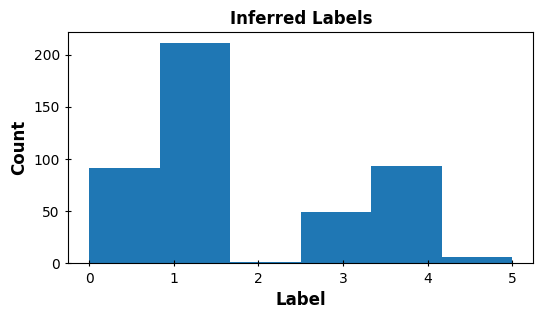

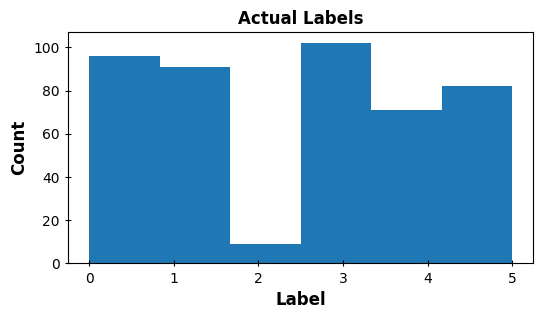

In [45]:
# visualize distrubtion of actual and inferred labels across test dataset
# NOTE: must be run AFTER running inference on test dataset

fig = plt.figure(0, figsize=(6, 3))
axs = plt.gca()
plt.title('Inferred Labels', fontweight = 'bold')
axs.hist(inf_list, 6)
axs.set_xlabel('Label', fontsize=12, fontweight='bold')
axs.set_ylabel('Count', fontsize=12, fontweight='bold')
axs.tick_params(direction='inout', length=5)
plt.show()

fig = plt.figure(1, figsize=(6, 3))
axs = plt.gca()
plt.title('Actual Labels', fontweight = 'bold')
axs.hist(act_list, 6)
axs.set_xlabel('Label', fontsize=12, fontweight='bold')
axs.set_ylabel('Count', fontsize=12, fontweight='bold')
axs.tick_params(direction='inout', length=5)
plt.show()

SNN:
rnn out 1:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 2:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 3:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 4:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
rnn out 5:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 6:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
rnn out 7:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 8:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 9:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 10:
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rnn out 11:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
(post-norm) final rnn out:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
output:
tensor([[-1.6883, -1.4222, -1.7910, -1.4785, -2.1060, -2.8565]],
       device='cuda:0')
ANN:
rnn out 1:
tensor([[0.4187, 0.0000, 0.0000, 0.1035, 0.9338, 0.0000, 4.2521, 2.7095, 0.0000,
  

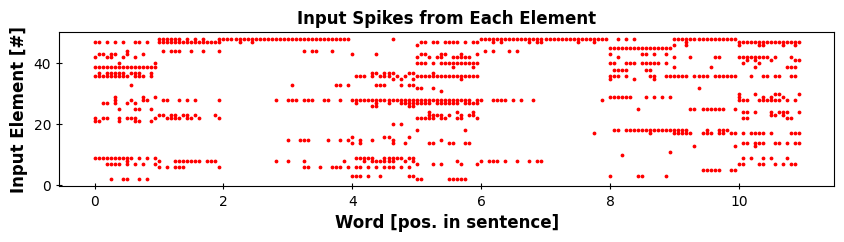

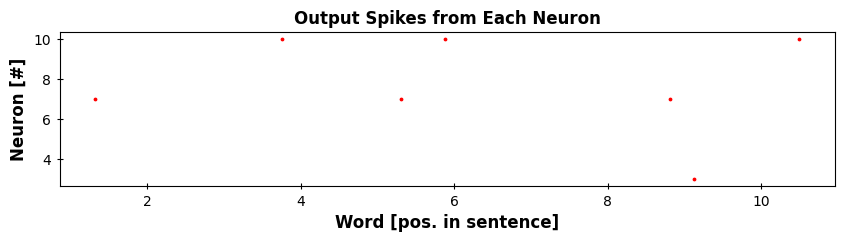

In [61]:
# visualize spikes over course of operation of one sentence

# perform inference on one sentence
t_b = 16
t_d = 16
global spike_words
spike_words = []
test_spikes(test_dataloader, snn_model, t_b, t_d, single=True, verbose=True, compare=True, ann_model = model)

# get spike times from input 
spike_words = np.concatenate(spike_words, axis=1)
num_in_dim = spike_words.shape[0]
all_spikes_in = np.empty((0, 2))
for i in range(num_in_dim):
    spike_idxs = np.nonzero(spike_words[i])[0]
    inp_num = np.ones(len(spike_idxs)) * (i+1)
    spikes_i = np.append([inp_num], [spike_idxs], axis = 0).astype(int).T
    all_spikes_in = np.append(all_spikes_in, spikes_i, axis=0)

# get times of all spikes for all neurons in recurrent layer
neur_list = snn_model.rnn.layers[0].neur_list
num_neurons = len(neur_list)
all_spikes_out = np.empty((0, 2))
for i in range(num_neurons):
    spike_idxs = np.nonzero(neur_list[i].spikes_out)[0]
    neuron_num = np.ones(len(spike_idxs)) * (i+1)
    spikes_i = np.append([neuron_num], [spike_idxs], axis = 0).astype(int).T
    all_spikes_out = np.append(all_spikes_out, spikes_i, axis=0)

# plot spikes from input
fig = plt.figure(2, figsize=(10, 2))
axs = plt.gca()
plt.title('Input Spikes from Each Element', fontweight = 'bold')
axs.scatter(all_spikes_in[:, 1] / t_b, all_spikes_in[:, 0], c='red', s = 3)
axs.set_xlabel('Word [pos. in sentence]', fontsize=12, fontweight='bold')
axs.set_ylabel('Input Element [#]', fontsize=12, fontweight='bold')
axs.tick_params(direction='inout', length=5)
plt.show()

# plot spikes over the course of processing sentence
fig = plt.figure(3, figsize=(10, 2))
axs = plt.gca()
plt.title('Output Spikes from Each Neuron', fontweight = 'bold')
axs.scatter(all_spikes_out[:, 1] / t_b, all_spikes_out[:, 0], c='red', s = 3)
axs.set_xlabel('Word [pos. in sentence]', fontsize=12, fontweight='bold')
axs.set_ylabel('Neuron [#]', fontsize=12, fontweight='bold')
axs.tick_params(direction='inout', length=5)
plt.show()

# clear spiking neuron data so we can test another question
snn_model.rnn.clear_lays()

In [29]:
vec = np.array([ 1, 3, 0, 0, 2, 0, 1, 0, 2, 2, 3, 7, 3, 4, 4, 4])
dotp = np.dot(w_4, vec)
softm = np.log(np.exp(dotp) / np.sum(np.exp(dotp)))
print(dotp)
print(softm)

[  1.52256761   0.53283232 -16.94716465  -5.42094155  -8.20751115
  -2.98547846]
[ -0.32477508  -1.31451037 -18.79450735  -7.26828425 -10.05485385
  -4.83282115]


In [35]:
np.max(w_3)

1.4225314

In [28]:
np.max(w_2[1])

-0.7016051